In [ ]:
# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical


# Graphing Style
%matplotlib inline

# Data Cleaning and Exploratory  Data Analysis

In [ ]:
face = pd.read_csv("face.csv")

In [ ]:
face.shape

(28709, 2)

In [ ]:
face["pixels"] = face.pixels.apply(lambda x: np.array(tuple(map(int, x.split()))))

In [ ]:
face.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [ ]:
face.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

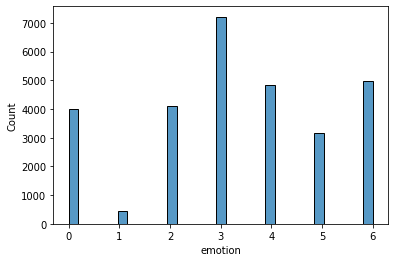

In [ ]:
sns.histplot(face.emotion)

In [ ]:
emo_di = {0: "Angry", 1:"Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

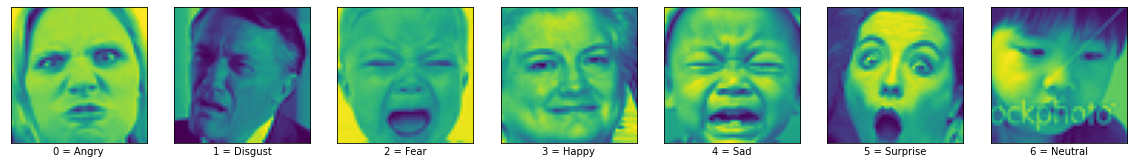

In [ ]:
plt.figure(figsize = (20,20))
start_index = 0
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(face[face.emotion == i].pixels.iloc[20].reshape(48,48))
    plt.xlabel("{} = {}".format(i, emo_di[i]))

For each one, consider using Cross Validation and/or PCA

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(np.concatenate(np.asarray(face["pixels"])).reshape(-1, 48 * 48), 
                                                    face.emotion, 
                                                    train_size=0.7, 
                                                    random_state=1)
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)


x_mean = np.mean(train_x)
x_std = np.std(train_x) + 1e-10
train_x = (train_x - x_mean) / x_std
val_x = (val_x - x_mean) / x_std
test_x = (test_x - x_mean) / x_std

# Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(train_x, train_y)

GaussianNB()

In [ ]:
nb.score(train_x, train_y)

0.2174562101910828

In [ ]:
nb.score(test_x, test_y)

0.2173206408172742

# K-Means + Logistic Regression

In [ ]:
pl = Pipeline([
    ("kmeans", KMeans(n_clusters=35)),
    ("logisreg", LogisticRegression(max_iter=10000))
])

In [ ]:
pl.fit(train_x, train_y)

Pipeline(steps=[('kmeans', KMeans(n_clusters=35)),
                ('logisreg', LogisticRegression(max_iter=10000))])

In [ ]:
pl.score(train_x, train_y)

0.2907046178343949

In [ ]:
pl.score(test_x, test_y)

0.300208962154632

# KNN with PCA + CV

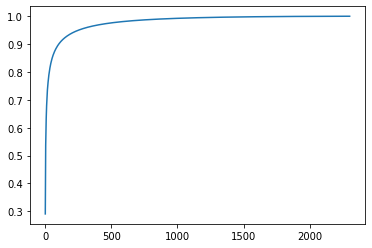

In [105]:
pca = PCA().fit(train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pl = Pipeline([
    ("PCA", PCA(n_components=100)),
    ("SVM", KNeighborsClassifier())
])
params = {"SVM__n_neighbors": [1, 3, 5, 7, 12, 15, 20]}
grids = GridSearchCV(pl, params, cv=5)
grids.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=100)),
                                       ('SVM', KNeighborsClassifier())]),
             param_grid={'SVM__n_neighbors': [1, 3, 5, 7, 12, 15, 20]})

In [ ]:
grids.best_params_

{'SVM__n_neighbors': 1}

In [ ]:
grids.best_score_

0.3501692953495771

In [ ]:
grids.best_estimator_.score(test_x, test_y)

0.3824007429765498

# Random Forest

In [ ]:
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(train_x, train_y)

RandomForestClassifier(max_depth=5)

In [ ]:
rfc.score(train_x, train_y)

0.33947054140127386

In [ ]:
rfc.score(test_x, test_y)

0.325748781054098

# Support Vector Machine with PCA

In [ ]:
pl = Pipeline([
               ("PCA", PCA(n_components=50)),
               ("svm", SVC())
])
pl.fit(train_x, train_y)

Pipeline(steps=[('PCA', PCA(n_components=50)), ('svm', SVC())])

In [ ]:
pl.score(train_x, train_y)

0.529110270700637

In [ ]:
pl.score(test_x, test_y)

0.4202461109821221

# Artificial Neural Network

In [ ]:
train_y_cat = to_categorical(train_y)
val_y_cat = to_categorical(val_y)
test_y_cat = to_categorical(test_y)

In [ ]:
model = Sequential()
model.add(Dense(256, activation = 'relu', input_shape = (48 * 48,)))
model.add(layers.Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               590080    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 657,671
Trainable params: 657,671
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_x, train_y_cat, epochs = 20, validation_data = (val_x, val_y_cat))

Epoch 1/20
628/628 [==============================] - 3s 4ms/step - loss: 1.9194 - accuracy: 0.2578 - val_loss: 1.6879 - val_accuracy: 0.3240
Epoch 2/20
628/628 [==============================] - 2s 4ms/step - loss: 1.7295 - accuracy: 0.3127 - val_loss: 1.6489 - val_accuracy: 0.3430
Epoch 3/20
628/628 [==============================] - 2s 4ms/step - loss: 1.6975 - accuracy: 0.3255 - val_loss: 1.6416 - val_accuracy: 0.3525
Epoch 4/20
628/628 [==============================] - 2s 4ms/step - loss: 1.6646 - accuracy: 0.3395 - val_loss: 1.6127 - val_accuracy: 0.3725
Epoch 5/20
628/628 [==============================] - 2s 4ms/step - loss: 1.6375 - accuracy: 0.3522 - val_loss: 1.5856 - val_accuracy: 0.3760
Epoch 6/20
628/628 [==============================] - 2s 4ms/step - loss: 1.6230 - accuracy: 0.3581 - val_loss: 1.5936 - val_accuracy: 0.3695
Epoch 7/20
628/628 [==============================] - 2s 4ms/step - loss: 1.6047 - accuracy: 0.3643 - val_loss: 1.5770 - val_accuracy: 0.3804
Epoch 

In [ ]:
model.evaluate(test_x, test_y_cat)

135/135 [==============================] - 0s 2ms/step - loss: 1.5339 - accuracy: 0.4165


[1.5338551998138428, 0.4165312349796295]

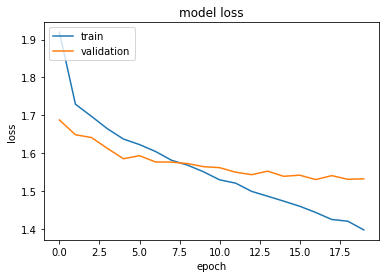

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

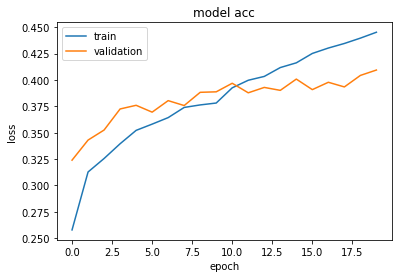

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
train_x_cnn = train_x.reshape(-1, 48, 48, 1)
val_x_cnn = val_x.reshape(-1, 48, 48, 1)
test_x_cnn = test_x.reshape(-1, 48, 48, 1)

In [ ]:
model2 = Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7))

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 21, 21, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 10, 10, 64)       

In [ ]:
history2 = model2.fit(train_x_cnn, train_y, epochs = 20, validation_data = (val_x_cnn, val_y))

Epoch 1/20
628/628 [==============================] - 11s 17ms/step - loss: 1.3236 - accuracy: 0.4935 - val_loss: 1.2828 - val_accuracy: 0.5288
Epoch 2/20
628/628 [==============================] - 11s 17ms/step - loss: 1.2908 - accuracy: 0.5005 - val_loss: 1.2522 - val_accuracy: 0.5362
Epoch 3/20
628/628 [==============================] - 11s 17ms/step - loss: 1.2902 - accuracy: 0.5046 - val_loss: 1.2851 - val_accuracy: 0.5369
Epoch 4/20
628/628 [==============================] - 10s 16ms/step - loss: 1.2828 - accuracy: 0.5089 - val_loss: 1.2514 - val_accuracy: 0.5367
Epoch 5/20
628/628 [==============================] - 11s 17ms/step - loss: 1.2763 - accuracy: 0.5104 - val_loss: 1.2417 - val_accuracy: 0.5460
Epoch 6/20
628/628 [==============================] - 11s 17ms/step - loss: 1.2686 - accuracy: 0.5152 - val_loss: 1.2644 - val_accuracy: 0.5344
Epoch 7/20
628/628 [==============================] - 10s 17ms/step - loss: 1.2630 - accuracy: 0.5131 - val_loss: 1.2503 - val_accuracy:

In [ ]:
model2.evaluate(test_x_cnn, test_y)

135/135 [==============================] - 1s 5ms/step - loss: 1.2030 - accuracy: 0.5544


[1.202962040901184, 0.554446280002594]

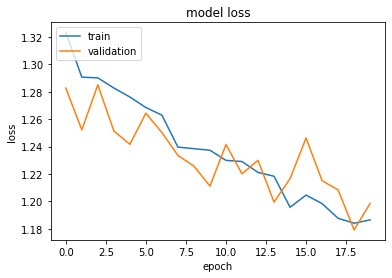

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

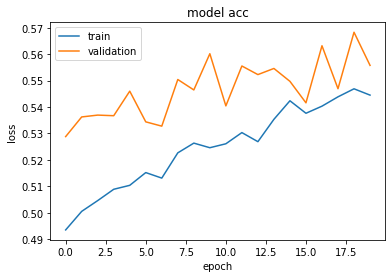

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# model.save('saved_model/ann')
# model2.save('saved_model/cnn')